## Hull-White model:

 - The Hull-White model is an interest rate model used to describe the evolution of interest rates over time. It assumes that the short rate follows a mean-reverting stochastic process.
- The model is defined by the following stochastic differential equation (SDE):
     
     $dr(t) = (\theta(t) - \alpha r(t)) dt + \sigma dW(t)$
     
     where $ \theta(t) $ is a time-dependent parameter, $ \alpha $ is the mean-reversion rate, $ \sigma $ is the volatility, and $ W(t) $ is a Wiener process.

### Simulating the Hull-White processes using Euler–Maruyama method

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def hull_white_simulation(a, sigma, r0, T, dt, theta):
    N = int(T / dt)
    times = np.linspace(0, T, N + 1)
    rates = np.zeros(N + 1)
    rates[0] = r0
    
    for i in range(1, N + 1):
        t = times[i - 1]
        dr = (theta(t) - a * rates[i - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[i] = rates[i - 1] + dr
    
    return times, rates    

In [34]:
a = 0.1
sigma = 0.1

a_array = np.array([i*0.02 for i in range(3,9)])  
sigma_array = np.array([i*0.006 for i in range(1,6)])

r0 = 0.03
T = 10.0     
dt = 0.01  

def theta(t):
    return 0.05

times_list = []
rates_list = []
for index in range(len(a_array)):
    times, rates = hull_white_simulation(a_array[index], sigma, r0, T, dt, theta)
    times_list.append(times)
    rates_list.append(rates)

for index in range(len(sigma_array)):
    times, rates = hull_white_simulation(a, sigma_array[index], r0, T, dt, theta)
    times_list.append(times)
    rates_list.append(rates)

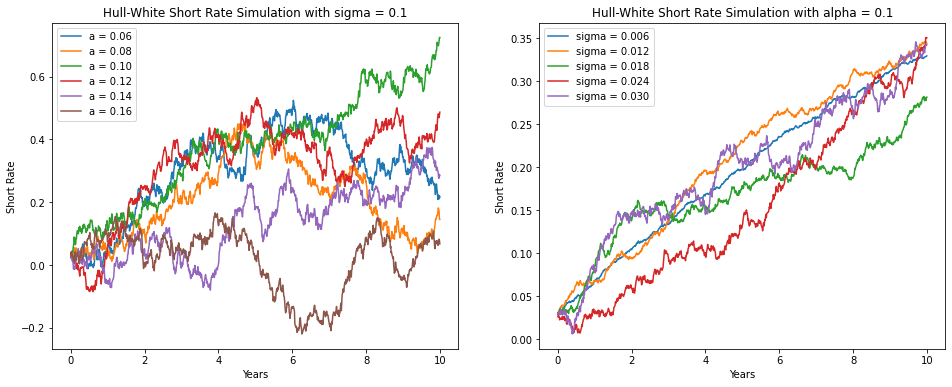

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# first graphs 
for i in range(len(a_array)):
    axs[0].plot(times_list[i], rates_list[i], label=f'a = {a_array[i]:.2f}')

axs[0].set_xlabel('Years')
axs[0].set_ylabel('Short Rate')
axs[0].set_title('Hull-White Short Rate Simulation with sigma = 0.1')
axs[0].legend()

# second graphs
for i in range(len(a_array), len(a_array) + len(sigma_array)):
    axs[1].plot(times_list[i], rates_list[i], label=f'sigma = {sigma_array[i - len(a_array)]:.3f}')

axs[1].set_xlabel('Years')
axs[1].set_ylabel('Short Rate')
axs[1].set_title('Hull-White Short Rate Simulation with alpha = 0.1')
axs[1].legend()
plt.show()

## Additionally

### Example on real data data downloading from fred "https://fred.stlouisfed.org/series/DSWP10"

250


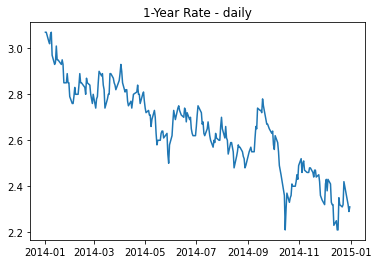

In [36]:
#!pip install pandas_datareader
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt 

# Ranges of data
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2015, 1, 1)

# Downloading data from FRED
symbol = 'DSWP10'
data = web.DataReader(symbol, 'fred', start, end)
data = data.dropna()

# plot
print(len(data[symbol]))
plt.plot(data)
plt.title("1-Year Rate - daily") 
plt.show()

In [37]:
import numpy as np

# checking mean and sigma of our Rates 
mean = data['DSWP10'].mean()   
std = data['DSWP10'].std()

print(f"Mean of swaps rates is : {mean}\nSigma of rates is : {std}")

Mean of swaps rates is : 2.65156
Sigma of rates is : 0.18716969943220557


In [38]:
# Calculating log returns

log_returns = np.log(data['DSWP10'] / data['DSWP10'].shift(1))
log_returns = log_returns.dropna()

In [39]:
# Naive estimation

mu = log_returns.mean() # mean of log returns
sigma = log_returns.std() # diffusion estimation as std from log returns
print(f"mean of log returns: {mu}\ndiffusion estimation: {sigma}")

mean of log returns: -0.0011422893054835474
diffusion estimation: 0.015617365358948494


In [40]:
sig_1 = np.sqrt(np.mean(np.power(log_returns,2)))*np.sqrt(250.)   # diffusion coefficient
mu_1 = (np.mean(log_returns) + 0.5 * (sig_1**2) / 250.)*250.  # drift coefficient

In [41]:
print(f"drift coefficient: {mu_1}\ndiffusion coefficient : {sig_1}")

drift coefficient: -0.25504390148298056
diffusion coefficient : 0.24709684290944045


### Alpha estiamation

In [42]:
# Estimation alpha
# parameters for alpha estimation
N = len(data['DSWP10'])
T = 1.0  # 1 year
h = T / N

sum1 = sum(np.power(data['DSWP10'].iloc[i-1], 2) for i in range(1, N))
sum2 = sum(data['DSWP10'].iloc[i-1] * data['DSWP10'].iloc[i] for i in range(1, N))

a = (1 / h) * np.log(sum1 / sum2)
a

0.3189140758369657

In [43]:
r0 = data['DSWP10'].iloc[0]          
dt = float(T / N)

def theta(t):            
    return mu_1

# estimation with parameters
hull_rates = hull_white_simulation(a, sig_1, r0 , T, dt , theta)[1]
hull_rates = hull_rates[:-1]

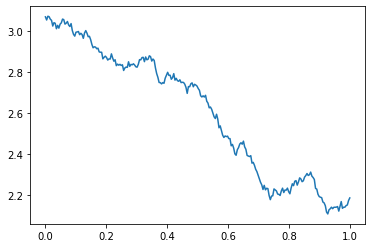

In [44]:
# plot of hull_rates

time_h = np.linspace(0.,1.,N)

plt.plot(time_h, hull_rates)
plt.show()

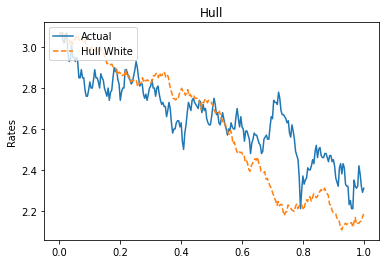

In [45]:
# actual and hull_rates

time = np.linspace(1, len(data[symbol]), len(data[symbol]))
time = [i/250. for i in time]
plt.plot(time, data[symbol], label = 'Actual')
plt.plot(time_h, hull_rates, label = 'Hull White', ls='--')

plt.ylabel('Rates')
plt.title('Hull')

plt.legend(loc = 'upper left')
plt.show()